In [2]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
# 导入数据
data_path = 'hour.csv'
rides = pd.read_csv(data_path)

In [4]:
# 将类型变量转为独热编码
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    # 提取类型变量数据，并将它们转为独热编码
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    # 将新的独热编码和原有数据合并
    rides = pd.concat([rides, dummies], axis=1)

# 将原来的类型变量删除
fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)


In [5]:
# 数值变量的处理（标准化）
quant_features = ['cnt', 'temp', 'hum', 'windspeed']
scaled_features = {} # 存储每个数组变量列的均值和方差
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean) / std


C:\Users\xiaogang\AppData\Local\Temp\ipykernel_9908\2392880189.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.95631172 -0.82399838 -0.86810283 ... -0.54834558 -0.7082242
 -0.77438087]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, each] = (data[each] - mean) / std


In [ ]:
# 准备数据
test_data = data[-21*24:]
train_data = data[:-21*24]

target_fields = ['cnt', 'casual', 'registered']

# 将训练集划分为特征变量列和目标特征列
features, targets = train_data.drop(target_fields, axis=1), train_data[target_fields]

# 将测试集划分为特征变量列和目标特征列
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

# 将数据类型转换为NumPy数组
X = features.values
X = X.astype(float)
Y = targets['cnt'].values
Y = Y.astype(float)
Y = np.reshape(Y, [len(Y), 1])



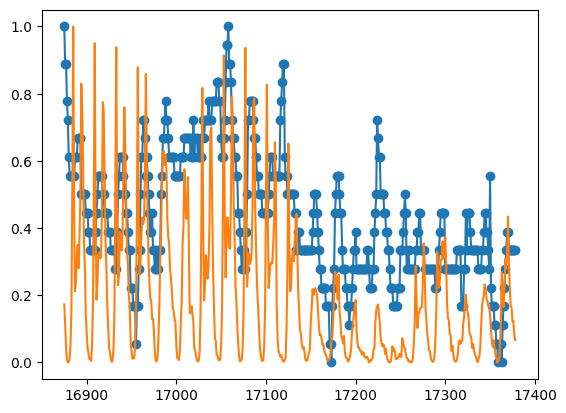

In [ ]:
test_features.to_csv('test_features.csv')

In [7]:
# 构建神经网络
input_size = features.shape[1] # 输入层
hidden_size = 10 # 隐含层的10个单元
output_size = 1 # 输出单元1个
batch_size = 128 
neu = torch.nn.Sequential( # 神经网络
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size)
)

cost = torch.nn.MSELoss() # 计算均方差的损失函数

optimizer = torch.optim.SGD(neu.parameters(), lr = 0.01) # 优化器

In [8]:
X

array([[ 0.        ,  0.        , -1.33460919, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.        ,  0.        , -1.43847501, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.        ,  0.        , -1.43847501, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.        ,  0.        ,  0.11951233, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.        , -0.19208513, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.        , -0.19208513, ...,  0.        ,
         0.        ,  0.        ]], shape=(16875, 56))

0 0.056810968
100 0.056618143
200 0.056438576
300 0.056268774
400 0.056106374
500 0.055949852
600 0.05579824
700 0.05565092
800 0.055507537
900 0.05536781


Text(0, 0.5, 'MSE')

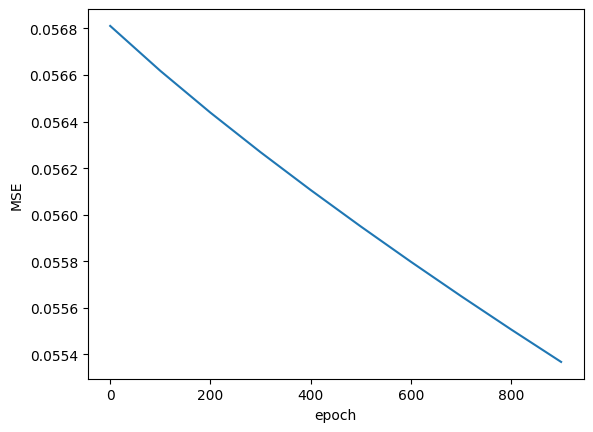

In [49]:
# 训练模型
losses = []
for i in range(1000):
    batch_loss = []
    for start in range(0, len(X), batch_size):
        end = start + batch_size if start + batch_size < len(X) else len(X)
        xx = torch.FloatTensor(X[start:end])
        yy = torch.FloatTensor(Y[start:end])
        predict = neu(xx)
        loss = cost(predict, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.data.numpy())
    if i % 100 == 0:
        mean_batch_loss = np.mean(batch_loss)
        losses.append(mean_batch_loss)
        print(i, mean_batch_loss)

plt.plot(np.arange(len(losses)) * 100, losses)
plt.xlabel('epoch')
plt.ylabel('MSE')


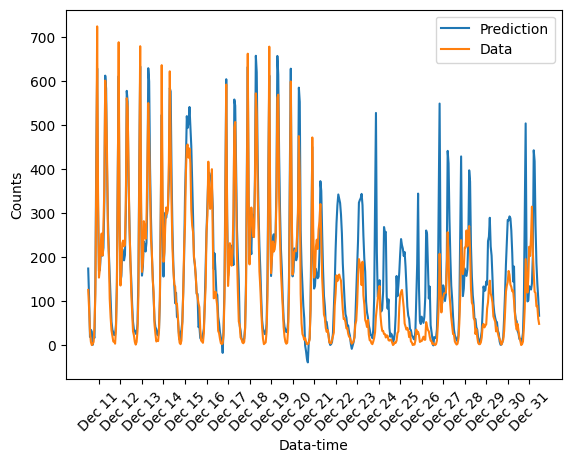

In [10]:
# 检验模型
targets = test_targets['cnt'] # 只预测目标变量的cnt
targets = targets.values.reshape([len(targets), 1])
targets = targets.astype(float) 

x = torch.FloatTensor(test_features.values.astype(float))
y = torch.FloatTensor(targets) # 测试集的单车数量，已被标准化
predict = neu(x)
predict = predict.data.numpy()

fig, ax = plt.subplots()

mean, std = scaled_features['cnt'] # cnt列的均值和方差
ax.plot(predict * std + mean, label='Prediction')
ax.plot(targets * std + mean, label='Data')
ax.legend()
ax.set_xlabel('Data-time')
ax.set_ylabel('Counts')
dates = pd.to_datetime(rides.loc[test_data.index]['dteday']) # 获取测试集的日期列
dates = dates.apply(lambda d: d.strftime('%b %d')) # 转成‘月份 日’
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)



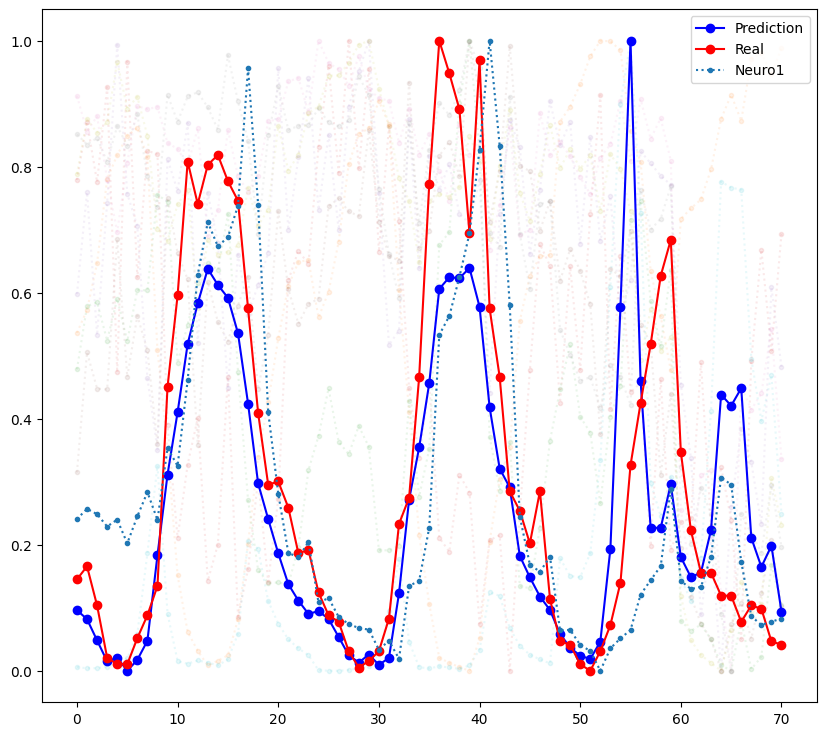

In [75]:
# 剖析神经网络Neu
# 用于提取网络的隐含层的激活值
def feature(X, net):
    X = torch.from_numpy(X).type(torch.FloatTensor)
    dic = dict(net.named_parameters())
    weights = dic['0.weight'] # 可以按照‘层数.名称’来索引集合中的相应参数值
    biases = dic['0.bias']
    h = torch.sigmoid(X.mm(weights.t())) + biases.expand([len(X), len(biases)])
    return h

bool1 = rides['dteday'] == '2012-12-22'
bool2 = rides['dteday'] == '2012-12-23'
bool3 = rides['dteday'] == '2012-12-24'

# 将三个布尔数组求或
bools = [any(tup) for tup in zip(bool1, bool2, bool3)] 
subset = test_features.loc[rides[bools].index]
subtargets = test_targets.loc[rides[bools].index]
subtargets = subtargets['cnt']
subtargets = subtargets.values.reshape([len(subtargets), 1]) # 这三天的cnt标签值，变量类型为ndarray

# 将数据输入到神经网络中，读取隐含层神经元的激活值，存入results
results = feature(subset.values.astype(float), neu).data.numpy()
# 这些数据对应的预测值
predict = neu(torch.FloatTensor(subset.values.astype(float))).data.numpy() 
# 去标准化
mean, std = scaled_features['cnt']
predict = predict * std + mean
subtargets = subtargets * std + mean

# 画图
fig, ax = plt.subplots(figsize = (10, 9))
for i in range(10):
    result = results[:, i]
    result = (result - min(result)) / (max(result) - min(result))
    ax.plot(result, '.:', alpha=0.1)  
ax.plot((predict - min(predict)) / (max(predict) - min(predict)), 'bo-', label='Prediction') # 加了归一化处理
ax.plot((subtargets - min(subtargets)) / (max(subtargets) - min(subtargets)), 'ro-', label='Real') 
neu_number = 0
ax.plot((results[:, neu_number] - min(results[:, neu_number])) / (max(results[:, neu_number] - min(results[:, neu_number]))), '.:', label='Neuro1')
# ax.set_xlim(right=len(predict))
ax.legend()


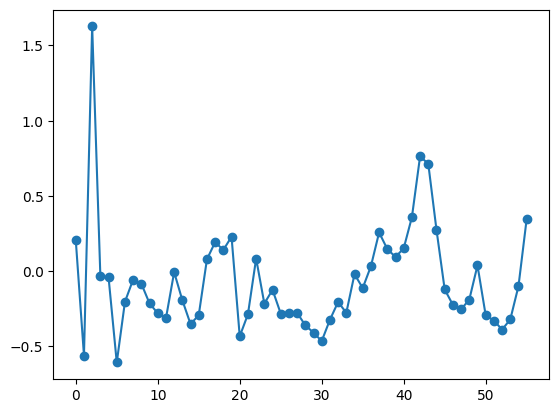

In [ ]:
# 发现第一个神经元对预测准确性贡献最大
# 将这个神经元的输入权重可视化
dic = dict(neu.named_parameters())
weights = dic['0.weight']
plt.plot(weights.data.numpy()[0, :], 'o-', label='隐含层第一个神经元的输入权重')



In [ ]:
# 发现temp的权重较大